In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

import sys

workDir = "/home/bop/Documents/2st-magistrsko_delo/code/mobile-network-anomaly-detection"
sys.path.append(workDir + "/src/")
from measurementDevice import Device
import seriesResample as sr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/usr/local/lib64/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [17]:
# set notebook configuration
IPERF_TCP_DL_ONLY = True
ALL_IPERF = False

timeGroupPeriodMin = 0.05

# select the analysis mode
analysisMode = IPERF_TCP_DL_ONLY

# default figure size for inline plots
defFigSize = (15, 8)


In [12]:
# read csv dataset

radioCellIdSubset = True
radioCellIds = np.array([263682.0, 271361.0], dtype=np.float64)

radioLTEBandSubset = True
radioLTEBands = [3]

radioLTEBwSubset = True
radioLTEBws = [20.0]

deviceDropSubset = True
deviceHashDropSubset = '776ed8bbb94944f7f8dce18edbaa9b75aAndroid'

deviceSubset = False
deviceHashSubset = '21b8982e9f2bf9ec357106864c2775345Android'

columnSubset = ['timestamp', 'hash', 'radio_ca_state', 'radio_rsrp_dbm', 'radio_rsrq_db', 'radio_rssi_dbm',
                'radio_sinr_db', 'radio_tx_power_dbm', 'radio_test_type', 'bw_intensive_test']
columnSubsetSum = ['timestamp', 'bw_intensive_test']

resultsFolder = "../results/"
filenameRadio = workDir + "/datasets/20190508_radio_samsung.csv"
data_radio_raw = pd.read_csv(filepath_or_buffer=filenameRadio, sep=',', decimal='.', parse_dates=['timestamp'])
# print(data_radio_raw.info(verbose=True))



In [13]:
print("\nbefore filter: ", data_radio_raw.shape)

if radioCellIdSubset:
    data_radio_raw = data_radio_raw.loc[data_radio_raw.radio_cell_id.isin(radioCellIds)]

if radioLTEBandSubset:
    data_radio_raw = data_radio_raw.loc[data_radio_raw.radio_band.isin(radioLTEBands)]

if radioLTEBwSubset:
    data_radio_raw = data_radio_raw.loc[data_radio_raw.radio_bw_mhz.isin(radioLTEBws)]

if deviceDropSubset:
    data_radio_raw = data_radio_raw.loc[~data_radio_raw.hash.str.contains(deviceHashDropSubset)]
    
if deviceSubset:
    data_radio_raw = data_radio_raw.loc[data_radio_raw.hash.str.contains(deviceHashSubset)]

print("\nafter filter: ", data_radio_raw.shape)



before filter:  (780393, 46)



after filter:  (500111, 46)


In [14]:
# add a column which specifies a bandwidth - intensive test
radioTestTypes = ['dns_test',
                  'download_test',
                  'iperf_test',
                  'ping_test',
                  'sleep_between_measurements',
                  'web_test',
                  'upload_test']

# bwIntensiveTests = ['iperf_test', 'download_test', 'upload_test']
bwIntensiveTests = ['iperf_test']
bwIntensiveTestsIds = [radioTestTypes.index(test) for test in bwIntensiveTests]

# drop all FTP dl tests as they may interfere with the results
data_radio_raw = data_radio_raw.loc[data_radio_raw.radio_test_type != "download_test"]

data_radio_raw['radio_test_type'] = sr.column_assign_categorical_type(data_radio_raw['radio_test_type'], radioTestTypes)
data_radio_raw['radio_test_type_encoded'] = sr.column_assign_categorical_type(data_radio_raw['radio_test_type']).cat.codes


def find_intensive_test(test_id, intensive_test_ids):
    # returns True if test_id is in the intensive_test_ids
    return test_id in intensive_test_ids


# find the bw - intensive tests in the dataset
data_radio_raw['bw_intensive_test'] = data_radio_raw.radio_test_type_encoded.apply(lambda x: find_intensive_test(x, bwIntensiveTestsIds))
data_radio_raw['bw_intensive_test'] = data_radio_raw['bw_intensive_test'].astype('int8')

In [15]:
# cross compare with iperf measurement result data and subselect rows
iperfDataPickle = workDir + "/datasets/iperf_rsrq_kbps_relation.pkl"
iperfSelectionData = pd.read_pickle(iperfDataPickle)

# init to non-bw intensive measurements
radioDataIperfDlActive = data_radio_raw.loc[data_radio_raw.bw_intensive_test == 0]
hashes = data_radio_raw.hash.unique()


# add entries when iperf TCP DL test was active
for devHash in hashes:    
    iperfSelectionDataDev = iperfSelectionData.loc[iperfSelectionData.hash == devHash]
    # print(iperfSelectionDataDev.head())
    
    radioSubData = data_radio_raw.loc[data_radio_raw.hash == devHash]
    # print(radioSubData.shape)
    
    iperfMask = radioSubData.timestamp == "1995-02-19 00:00:00"
    
    for index, row in iperfSelectionDataDev.iterrows():
        iperfMask = iperfMask | ((radioSubData.timestamp >= row.iperf_test_start) & 
                                 (radioSubData.timestamp <= row.timestamp))
    
    # print(iperfMask.value_counts())
    
    radioDataIperfDlActive = radioDataIperfDlActive.append(radioSubData.loc[iperfMask])


In [16]:
if analysisMode:
    dataRadioSubset = radioDataIperfDlActive[columnSubset]
else:
    dataRadioSubset = data_radio_raw[columnSubset]


Text(0, 0.5, 'number of active bandwidth measurements')

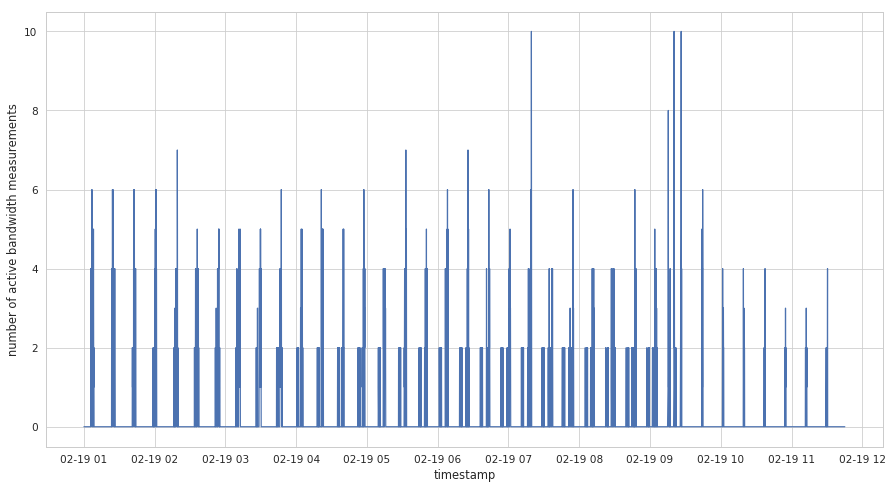

In [19]:
# analyze all of the devices together
dataAllDevicesMean = sr.resample_series(dataRadioSubset, timeGroupPeriodMin, 'mean').reset_index()
dataAllDevicesSum = sr.resample_series(dataRadioSubset[columnSubsetSum], timeGroupPeriodMin, 'sum').reset_index()

# merge the aggregated into a single dataframe
dataAllDevicesAgg = dataAllDevicesMean.merge(dataAllDevicesSum, how='left', on='timestamp')
dataAllDevicesAgg = dataAllDevicesAgg.rename(columns={'bw_intensive_test_x': 'bw_intensive_test_mean',
                                                      'bw_intensive_test_y': 'bw_intensive_test_sum'})
dataAllDevicesAgg = dataAllDevicesAgg.dropna(axis='rows', how='any')

fig, axes = plt.subplots(figsize=defFigSize, nrows=1, ncols=1, sharex='all', squeeze=True)
axes.plot(dataAllDevicesAgg.timestamp, dataAllDevicesAgg.bw_intensive_test_sum)
axes.set_xlabel("timestamp")
axes.set_ylabel("number of active bandwidth measurements")


In [21]:
# check RSRQ to number of bw-intensive measurements relationship per individual device
maColumns = ['radio_rsrq_db']
maWindowSize = 1
devHashes = dataRadioSubset.hash.unique()

def rolling_mean(group, columns=None, win_size=5, win_type="hamming"):
    # @brief computes the moving average for the selected subset of columns
    
    if columns is not None:
        group[columns] = group[columns].rolling(window=win_size, win_type=win_type, min_periods=1).mean() 
    return group
    
    
def sync_measurement_timestamps(group, time_period, sum_columns):
    # @brief groups the data frame measurements together in time_period interval and applies the aggregation functions.
    
    group_period_s = str(time_period) + 's'

    group_means = group.resample(group_period_s, on='timestamp').apply('mean').reset_index()
    group_max = group[sum_columns].resample(group_period_s, on='timestamp').max()
    group_max = group_max.drop(axis='columns', labels='timestamp').reset_index()

    group_agg = group_means.merge(group_max, how='left', on='timestamp')
    
    # if there was a test active in current period, bw_intensive_test_max will be true
    group_agg = group_agg.rename(columns={'bw_intensive_test_x': 'bw_intensive_test_mean',
                                          'bw_intensive_test_y': 'bw_intensive_test_max'})
    group_agg = group_agg.dropna(axis='rows', how='any')
    return group_agg
    

# apply moving average to rsrq for each device
devices = dataRadioSubset.reset_index().groupby(pd.Grouper(key='hash'))
devices = devices.apply(lambda x: rolling_mean(x, maColumns, maWindowSize))

devices = devices.loc[(devices.timestamp > '2019-02-18 22:00:00') & (devices.timestamp < '2019-02-19 04:00:00')]

# group by a very short time period - synchronize the measurement timestamps
timeGroupPeriodS = 2

devices = devices.groupby(pd.Grouper(key='hash'))
devices = devices.apply(lambda x: sync_measurement_timestamps(x, timeGroupPeriodS, columnSubsetSum)).reset_index()
devices = devices.drop(axis='columns', labels='level_1')

print(devices.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31256 entries, 0 to 31255
Data columns (total 10 columns):
hash                      31256 non-null object
timestamp                 31256 non-null datetime64[ns]
index                     31256 non-null float64
radio_rsrp_dbm            31256 non-null float64
radio_rsrq_db             31256 non-null float64
radio_rssi_dbm            31256 non-null float64
radio_sinr_db             31256 non-null float64
radio_tx_power_dbm        31256 non-null float64
bw_intensive_test_mean    31256 non-null float64
bw_intensive_test_max     31256 non-null float64
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 2.4+ MB
None


In [24]:
def agg_sum(group):
    tests_sum = group.bw_intensive_test_max.sum()
    group = group.iloc[0]
    group.bw_intensive_test_max = tests_sum
    return group


resultsColnames = ['n_concurrent_tests', 'hash', 'rsrq_mean', 'rsrq_std', 'radio_measurement_count']
radioToDevicesResults = pd.DataFrame(columns=resultsColnames)

comparissonDataColnames = ['timestamp', 'hash', 'n_concurrent_tests', 'radio_rsrq_db']
comparissonDataOut = pd.DataFrame(columns=comparissonDataColnames)

for hash in devHashes:
    device = devices.loc[devices.hash == hash]
    otherDevices = devices.loc[devices.hash != hash]
    
    # sum up the number of bw intensive tests for the remaining devices
    otherDevicesAgg = otherDevices[['timestamp', 'bw_intensive_test_max']].groupby('timestamp', group_keys=True)
    otherDevicesAgg = otherDevicesAgg.apply(agg_sum).drop(axis='columns', labels='timestamp').reset_index()
    
    device = device[['timestamp', 'radio_rsrq_db', 'bw_intensive_test_max']]

    # select only measurements matching to the device's
    comparissonData = device.merge(otherDevicesAgg, how='left', on='timestamp')
    comparissonData['bw_intensive_test_max'] = comparissonData['bw_intensive_test_max_x'] + comparissonData['bw_intensive_test_max_y']
    
    comparissonData = comparissonData.rename(columns={'bw_intensive_test_max': 'n_concurrent_tests'})
    comparissonData['hash'] = hash  
    comparissonDataOut = comparissonDataOut.append(comparissonData, sort=False)


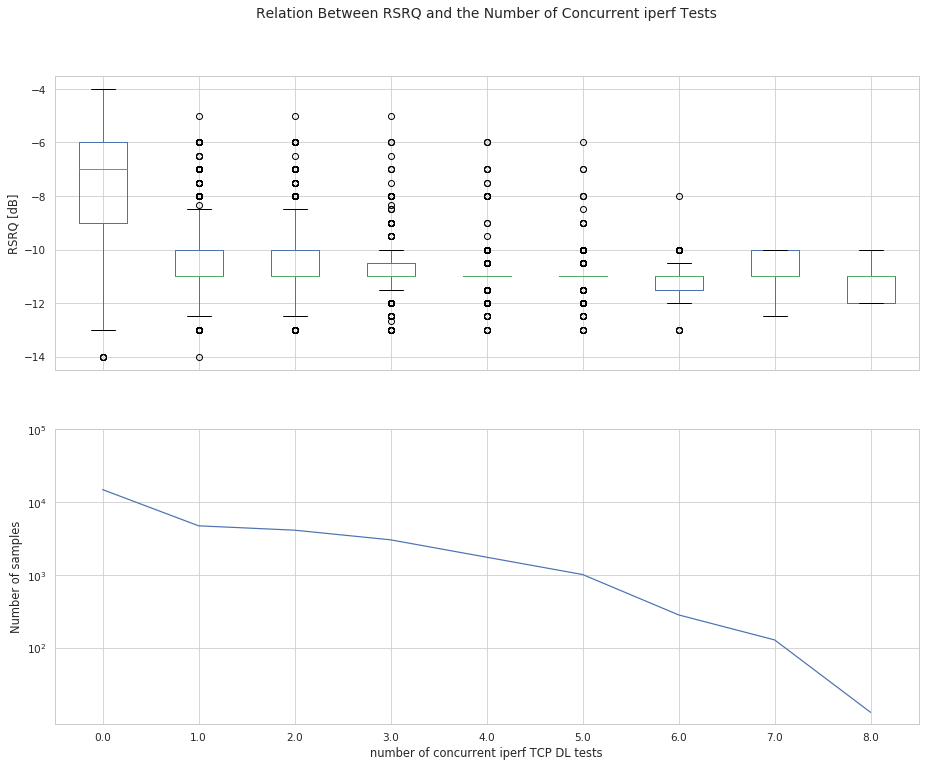

In [23]:
# count the number of samples per number of tests
counts = comparissonDataOut.groupby(pd.Grouper(key='n_concurrent_tests')).agg('count')
counts = counts.sort_index().reset_index()

plt.close("all")
fig, axes = plt.subplots(nrows=2, ncols=1, sharex='all', squeeze=True, figsize=(15, 12))
comparissonDataOut[['n_concurrent_tests', 'radio_rsrq_db']].boxplot(ax=axes[0], by='n_concurrent_tests')

boxplotTitle = "Relation Between RSRQ and the Number of Concurrent iperf Tests"
xLabel = "number of concurrent iperf TCP DL tests"

axes[0].set_ylabel("RSRQ [dB]")
axes[0].set_xlabel("")
axes[0].set_title("")
fig.suptitle(boxplotTitle)

axes[1].semilogy(counts.n_concurrent_tests + 1, counts.timestamp)
axes[1].set_ylabel("Number of samples")
axes[1].set_xlabel(xLabel)
axes[1].set_yticks([100, 1000, 10000, 100000])